### **INSTALL AND IMPORT REQUIRED PACKAGES**

In [1]:
!pip install cartopy biopython gpustat transformers datasets scikit-learn --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.7/84.7 kB 4.6 MB/s eta 0:00:00


### **IMPORT REQUIRED PACKAGES**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import sys
import gc
from platform import python_version
import random
import warnings
warnings.filterwarnings('ignore')

print("Packages installed and imported successfully!")
print("Python version", python_version())
print("Pytorch - version", torch.__version__)
print("Pytorch - cuDNN version :", torch.backends.cudnn.version())

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

Packages installed and imported successfully!
Python version 3.11.13
Pytorch - version 2.6.0+cu124
Pytorch - cuDNN version : 90300
Using device: cuda
GPU: Tesla T4
GPU Memory: 14 GB


### **SET RANDOM SEED**

In [3]:
# Set all seeds for reproducibility
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_all_seeds(42)
print("All seeds set for reproducibility.")

All seeds set for reproducibility.


### **LOAD THE BALANCED DATA**

In [4]:
from google.colab import drive
# drive.mount('/content/drive/')
drive.mount('/content/drive/', force_remount=True)

WORKDIR = "/content/drive/MyDrive/Colab Notebooks/Seminar-AMR/"
DATA_DIR = os.path.join(WORKDIR, "data")
CODE_SOURCE_DIR = os.path.join(WORKDIR, "src")
GENE_OUTPUT_DIR = os.path.join(DATA_DIR, "genes")
RESULT_DIR = os.path.join(WORKDIR, "results")
sys.path.append(WORKDIR)

filename = os.path.join(RESULT_DIR, "balanced_original_data.csv")
df_all = pd.read_csv(filename)

df_train = df_all[df_all["split"] == "train"]
# df_val   = df_all[df_all["split"] == "val"]
df_test  = df_all[df_all["split"] == "test"]

seq_train, y_train = df_train["sequence"].tolist(), df_train["label"].tolist()
# seq_val, y_val     = df_val["sequence"].tolist(),   df_val["label"].tolist()
seq_test, y_test   = df_test["sequence"].tolist(),  df_test["label"].tolist()

print("Reloaded train/val/test splits from CSV")

seq_train, seq_val, y_train, y_val = train_test_split(
    seq_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

Mounted at /content/drive/
Reloaded train/val/test splits from CSV


### **HANDLE TRAINING CLASS IMABALANCE (CLASS WEIGHTAGE)**

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)                               # Calculate class weights for imbalanced training data
pos_weight = torch.tensor(class_weights[1] / class_weights[0], dtype=torch.float32).to(device)                        # We give higher weightage to minority class and lower weightage to majority class during loss calculation. We will use this weight while defining loss function criteria.

print(f"Class weights: Non-Resistant={class_weights[0]:.3f}, Resistant={class_weights[1]:.3f}")
print(f"Positive weight for BCE loss: {pos_weight.item():.3f}")

Class weights: Non-Resistant=1.800, Resistant=0.692
Positive weight for BCE loss: 0.385


### **CUSTOM FUNCTION FOR CLEANING GPU MEMORY**

In [8]:
def clean_gpu():
    torch.cuda.empty_cache()
    gc.collect()

## **SECTION: PRETRAINED TRANFORMER: DNABERT**

### **DNABERT DATASET CLASS**

In [9]:
from torch.nn.utils.rnn import pad_sequence
from transformers import AutoTokenizer

class DNABERTDataset(Dataset):
    """Dataset for DNABERT models using transformers tokenizer"""

    def __init__(self, sequences, labels, tokenizer, k=6, max_len=512):
        self.sequences = sequences
        self.labels = labels
        self.tokenizer = tokenizer
        self.k = k
        self.max_len = max_len

    def _validate_sequences(self):
        """Validate DNA sequences for common issues"""
        valid_chars = set('ATCGN')
        for i, seq in enumerate(self.sequences):
            seq_upper = seq.upper()
            invalid_chars = set(seq_upper) - valid_chars
            if invalid_chars:
                print(f"Warning: Sequence {i} contains invalid characters: {invalid_chars}")

            if len(seq) < self.k:
                print(f"Warning: Sequence {i} is shorter than k={self.k}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx].upper()
        label = self.labels[idx]

        kmers = self.generate_kmers(seq, self.k)                                # Generate k-mers with spaces for BERT tokenization
        if not kmers:                                                           # Handle edge case of very short sequences
            kmers = ['N' * self.k]                                              # Fallback k-mer
        kmers_spaced = " ".join(kmers)

        # Tokenize the k-mer sequence
        encoding = self.tokenizer(
            kmers_spaced,
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )

        # Squeeze the batch dimension added by the tokenizer
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": torch.tensor(label, dtype=torch.long)
        }

    @staticmethod
    def generate_kmers(sequence, k=6):
      return [sequence[i:i+k] for i in range(len(sequence) - k + 1)]

print("DNABERTDataset class defined!")

DNABERTDataset class defined!


### **DNABERT MODEL CLASS**

In [10]:
from transformers import AutoTokenizer, AutoModel, AutoConfig

class DNABERTClassifier(nn.Module):
    def __init__(self, model_name="zhihan1996/DNA_bert_6", num_classes=1, dropout=0.1, freeze_pretrained=False, pos_weight=None):
        super(DNABERTClassifier, self).__init__()

        print(f"Loading DNABERT model: {model_name}")
        self.dnabert = AutoModel.from_pretrained(model_name)

        if freeze_pretrained:
            for param in self.dnabert.parameters():
                param.requires_grad = False
            print("Pretrained DNABERT parameters frozen!")
        else:
            print("All DNABERT parameters will be fine-tuned (requires very low LR)!")

        config = AutoConfig.from_pretrained(model_name)                         # Get hidden size from config
        hidden_size = config.hidden_size

        # Classification head with dropout
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_classes)
        # nn.init.normal_(self.classifier.weight, std=0.02)                     # Initialize classifier weights
        # nn.init.zeros_(self.classifier.bias)

        self.pos_weight = pos_weight                                            # Store pos_weight for loss calculation
        if pos_weight is not None:
            print(f"Using class weight: {pos_weight.item():.4f}")

        print(f"DNABERT loaded with hidden size: {hidden_size}")

        # Count trainable parameters
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")

    def forward(self, input_ids, attention_mask):
        outputs = self.dnabert(input_ids=input_ids, attention_mask=attention_mask)

        # Use [CLS] token representation (first token)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, hidden_size]

        dropped_output = self.dropout(pooled_output)
        logits = self.classifier(dropped_output)

        return logits.squeeze(-1), pooled_output

print("DNABERTClassifier class defined!")

DNABERTClassifier class defined!


### **DNABERT MODEL CLASS WITH LoRA FOR PARAMETER-EFFICIENT FINE-TUNING**

In [11]:
from peft import LoraConfig, get_peft_model, TaskType, PeftModel

class DNABERTLoRAClassifier(nn.Module):
    """
    DNABERT model with LoRA adapters for parameter-efficient fine-tuning
    This approach freezes the base model and only trains LoRA adapters + classification head
    """
    def __init__(self, model_name="zhihan1996/DNA_bert_6", num_classes=1, dropout=0.1,
                 lora_r=16, lora_alpha=32, lora_dropout=0.1, pos_weight=None):
        super(DNABERTLoRAClassifier, self).__init__()

        print(f"Loading DNABERT model with LoRA: {model_name}")

        self.dnabert_lora = AutoModel.from_pretrained(model_name, trust_remote_code=True)

        for param in self.dnabert_lora.parameters():                                                                      # Freeze all parameters first
            param.requires_grad = False

        peft_config = LoraConfig(
            task_type=TaskType.FEATURE_EXTRACTION,
            inference_mode=False,
            r=lora_r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            target_modules=["query", "value"]                                   # Apply LoRA to attention layers
        )

        self.dnabert_lora = get_peft_model(self.dnabert_lora, peft_config)      # Apply LoRA to the model

        print("LoRA adapters added to DNABERT!")

        config = AutoConfig.from_pretrained(model_name, trust_remote_code=True) # Get hidden size from config
        # config.use_flash_attention = False
        hidden_size = config.hidden_size

        # Classification head
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_size, num_classes)
        nn.init.normal_(self.classifier.weight, std=0.02)                       # Initialize classifier weights
        nn.init.zeros_(self.classifier.bias)

        self.pos_weight = pos_weight                                            # Store pos_weight for loss calculation
        if pos_weight is not None:
            print(f"Using class weight: {pos_weight.item():.4f}")

        print(f"DNABERT + LoRA loaded with hidden size: {hidden_size}")

        # Count trainable parameters
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in self.parameters())
        print(f"Trainable parameters: {trainable_params:,} / {total_params:,}")
        print(f"LoRA trainable parameters: {self.dnabert_lora.get_nb_trainable_parameters()}")

    def forward(self, input_ids, attention_mask):

        outputs = self.dnabert_lora(input_ids=input_ids, attention_mask=attention_mask)                                   # Get DNABERT-2 outputs with LoRA
        pooled_output = outputs.last_hidden_state[:, 0, :]                                                            # Use [CLS] token representation
        dropped_output = self.dropout(pooled_output)                                                                   # Apply dropout and classification
        logits = self.classifier(dropped_output)

        return logits.squeeze(-1), pooled_output

print("DNABERTLoRAClassifier class defined!")

DNABERTLoRAClassifier class defined!


### **LOSS FUNCTION: MAX-MARGIN + FOCAL BCE**

In [12]:
import torch.nn.functional as F

def max_margin_loss(features, labels, margin=1.0, lambda_margin=0.1, temperature=0.1):
    """
    Max-Margin Loss for LSRTM (Lightweight Self-Regularized Transformer Model) goes beyond standard classification losses
    to enforce better geometric properties in the learned feature space.

    Args:
        features: [batch_size, embed_dim] - learned representations before classification
        labels: [batch_size] - binary labels (0 or 1)
        margin: minimum distance between different classes
        lambda_margin: weight for margin loss component
    """

    # Separate features by class
    class_0_features = features[labels == 0]  # Non-resistant
    class_1_features = features[labels == 1]  # Resistant

    if len(class_0_features) == 0 or len(class_1_features) == 0:
        return torch.tensor(0.0, device=features.device)

    # Intra-class compactness (minimize within-class distances) with temperature scaling
    intra_class_loss = 0.0

    if len(class_0_features) > 1:
        # Pairwise distances within class 0; Apply temperature scaling to make distances more sensitive
        dist_0 = torch.pdist(class_0_features / temperature, p=2)       # Euclidean distance
        intra_class_loss += dist_0.mean()

    if len(class_1_features) > 1:
        # Pairwise distances within class 1
        dist_1 = torch.pdist(class_1_features / temperature, p=2)
        intra_class_loss += dist_1.mean()

    # Inter-class separability (maximize between-class distances)
    # Compute centroids for each class
    centroid_0 = class_0_features.mean(dim=0)  # [embed_dim]
    centroid_1 = class_1_features.mean(dim=0)  # [embed_dim]

    # Cosine similarity based margin (better for high-dim spaces)
    cos_sim = F.cosine_similarity(centroid_0.unsqueeze(0), centroid_1.unsqueeze(0))
    margin_loss = torch.clamp(cos_sim + margin, min=0.0)  # Want negative cosine similarity

    # Additional: Minimize within-class variance
    if len(class_0_features) > 1:
        var_0 = torch.var(class_0_features, dim=0).mean()
    else:
        var_0 = 0.0

    if len(class_1_features) > 1:
        var_1 = torch.var(class_1_features, dim=0).mean()
    else:
        var_1 = 0.0

    variance_loss = var_0 + var_1

    total_loss = intra_class_loss + margin_loss + 0.1 * variance_loss
    return lambda_margin * total_loss

class FocalBCELoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, pos_weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight

    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(
            inputs, targets, pos_weight=self.pos_weight, reduction='none'
        )
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()

### **DNABERT TRAINING FUNCTION**

In [13]:
import torch.nn.functional as F
import copy

def train_dnabert_model(model, train_loader, val_loader, num_epochs=10, learning_rate=2e-5, device='cuda', pos_weight=None):
    """Train DNABERT model with early stopping"""

    model.to(device)
    if pos_weight is not None:
        criterion = FocalBCELoss(alpha=1.0, gamma=2.0, pos_weight=pos_weight)
        print(f"Using Focal BCE loss with pos_weight: {pos_weight.item():.4f}")
    else:
        criterion = nn.BCEWithLogitLoss() # Corrected typo here
        print("Using standard BCE loss")

    # Different optimizers and learning rates for frozen vs fine-tuned
    # Check if any parameters in the model require gradients (for both fine-tuning and LoRA)
    if any(p.requires_grad for p in model.parameters()):
        # Determine the base model attribute based on the model type
        base_model_attribute = None
        if hasattr(model, 'dnabert'):
            base_model_attribute = model.dnabert
            print(f"Model type: DNABERTClassifier")
        elif hasattr(model, 'dnabert_lora'):
            base_model_attribute = model.dnabert_lora
            print(f"Model type: DNABERTLoRAClassifier")
        else:
            print("Warning: Unknown model type detected. Optimizing all trainable parameters.")


        if base_model_attribute is not None and any(p.requires_grad for p in base_model_attribute.parameters()):
             optimizer = torch.optim.AdamW([
                {'params': base_model_attribute.parameters(), 'lr': learning_rate * 0.1},  # 10x lower for pretrained/LoRA base
                {'params': model.classifier.parameters(), 'lr': learning_rate}     # Normal for new layers
            ], weight_decay=0.01)
             print(f"Fine-tuning/LoRA mode: Base LR={learning_rate*0.1:.2e}, Classifier LR={learning_rate:.2e}")
        else:
             # Frozen: Only classifier parameters, can use higher learning rate
            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=0.01)
            print(f"Frozen mode: Classifier LR={learning_rate:.2e}")
    else:
        # Default case if no specific setup is detected, optimize all trainable parameters
        optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, weight_decay=0.01)
        print(f"General trainable parameters mode: LR={learning_rate:.2e}")


    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=4, verbose=True, min_lr=1e-7)

    best_val_f1 = -1
    best_model_state = None
    patience_counter = 0
    patience = 7

    history = {
        "train_loss": [], "val_loss": [],
        "train_accuracy": [], "train_precision": [], "train_recall": [], "train_f1": [], "train_roc_auc": [],
        "val_accuracy": [], "val_precision": [], "val_recall": [], "val_f1": [], "val_roc_auc": [],
        "learning_rate": []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        total_bce_loss = 0.0
        total_margin_loss = 0.0
        train_batches = 0

        loop = tqdm(train_loader, desc="Training", leave=False)
        for batch in loop:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].float().to(device)

            optimizer.zero_grad()
            logits, features = model(input_ids, attention_mask)
            bce_loss = criterion(logits, labels)
            margin_loss = max_margin_loss(features, labels.long(), margin=1.0, lambda_margin=0.1)
            total_loss = bce_loss + margin_loss
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += total_loss.item() * input_ids.size(0)
            total_bce_loss += bce_loss.item() * input_ids.size(0)
            total_margin_loss += margin_loss.item() * input_ids.size(0)
            # loop.set_postfix(loss=total_loss_batch.item())
            train_batches += 1


        if train_batches > 0: # Prevent division by zero if train_loader is empty
            avg_train_loss = train_loss / train_batches
            avg_bce_loss = total_bce_loss / train_batches
            avg_margin_loss = total_margin_loss / train_batches
        else:
            avg_train_loss = 0.0
            avg_bce_loss = 0.0
            avg_margin_loss = 0.0


        print(f"Train Loss -- Total: {avg_train_loss:.4f}, BCE: {avg_bce_loss:.4f}, Margin: {avg_margin_loss:.4f}")

        # Evaluation phase
        train_acc, train_prec, train_rec, train_f1, _, _, _, _ = eval_model_dnabert(model, train_loader, device)
        val_acc, val_prec, val_rec, val_f1, val_roc_auc, _, _, _ = eval_model_dnabert(model, val_loader, device)
        val_loss = test_loss_calc_dnabert(model, val_loader, criterion, device)

        # Store metrics
        history["train_loss"].append(avg_train_loss)
        history["val_loss"].append(val_loss)
        history["train_accuracy"].append(train_acc)
        history["train_precision"].append(train_prec)
        history["train_recall"].append(train_rec)
        history["train_f1"].append(train_f1)
        history["val_accuracy"].append(val_acc)
        history["val_precision"].append(val_prec)
        history["val_recall"].append(val_rec)
        history["val_f1"].append(val_f1)
        history["val_roc_auc"].append(val_roc_auc)
        history["learning_rate"].append(optimizer.param_groups[0]['lr'])

        # Get current learning rate (might be different for different param groups)
        current_lr = max([group['lr'] for group in optimizer.param_groups])
        history["learning_rate"].append(current_lr)

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Early stopping
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
            print(f"✅ New best validation F1: {val_f1:.4f}")
        else:
            patience_counter += 1

        print(f"Epoch {epoch+1:2d}/{num_epochs}: Val Accuracy: {val_acc:.4f}, Val Precision: {val_prec:.4f}, Val Recall: {val_rec:.4f}, Val F1: {val_f1:.4f}, Val ROC-AUC: {val_roc_auc:.4f}")

        # if train_loss > 10.0:
        #     print("Training loss explosion detected! Stopping early.")
        #     break

        # if patience_counter >= patience:
        #     print(f"Early stopping triggered at epoch {epoch+1}")
        #     break

    # Load best model
    model.load_state_dict(best_model_state)
    return model, history

print("DNABERT training function defined!")

DNABERT training function defined!


### **DNABERT EVALUATION HELPER FUNCTION**

In [14]:
def eval_model_dnabert(model, dataloader, device, optimal_threshold=None):
    """Evaluate DNABERT model"""
    model.eval()
    preds = []
    probs_all = []
    targets = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            logits, _ = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)

            probs_all.extend(probs.cpu().numpy())
            targets.extend(labels.cpu().numpy())

    # Convert to numpy arrays
    probs_all = np.array(probs_all)
    targets = np.array(targets)

    # Find optimal threshold using the targets and probs from the dataloader
    optimal_threshold, _ = find_optimal_threshold(targets, probs_all) # Pass numpy arrays

    # Use optimal threshold if provided, otherwise 0.5
    threshold = optimal_threshold if optimal_threshold is not None else 0.5
    preds = (probs_all > threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(targets, preds)
    prec = precision_score(targets, preds, zero_division=0)
    rec = recall_score(targets, preds, zero_division=0)
    f1 = f1_score(targets, preds, zero_division=0)

    try:
        roc_auc = roc_auc_score(targets, probs_all)
    except ValueError as e:
        print(f"ROC-AUC calculation failed: {e}")
        roc_auc = 0.0

    return acc, prec, rec, f1, roc_auc, preds, targets, probs_all

def find_optimal_threshold(targets, probs): # probs should be a numpy array
    """Find optimal threshold using F1 score"""
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1 = 0
    best_threshold = 0.5

    for threshold in thresholds:
        preds = (probs > threshold).astype(int) # probs is now numpy array
        f1 = f1_score(targets, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

print("Evaluation functions with threshold optimization!")

def test_loss_calc_dnabert(model, dataloader, criterion, device):
    """Calculate test loss for DNABERT model"""
    model.eval()
    total_loss = 0.0
    total_bce_loss = 0.0
    total_margin_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].float().to(device)

            logits, features = model(input_ids, attention_mask)

            bce_loss = criterion(logits, labels)
            margin_loss = max_margin_loss(features, labels.long(), margin=1.0, lambda_margin=0.1)
            loss = bce_loss + margin_loss

            total_loss += loss.item() * input_ids.size(0)
            total_bce_loss += bce_loss.item() * input_ids.size(0)
            total_margin_loss += margin_loss.item() * input_ids.size(0)
            num_batches += 1

    avg_total_loss = total_loss / num_batches
    avg_bce_loss = total_bce_loss / num_batches
    avg_margin_loss = total_margin_loss / num_batches

    print(f"Val Loss -- Total: {avg_total_loss:.4f}, BCE: {avg_bce_loss:.4f}, Margin: {avg_margin_loss:.4f}")
    return avg_total_loss

print("DNABERT evaluation helper functions defined!")

Evaluation functions with threshold optimization!
DNABERT evaluation helper functions defined!


### **CALCULATE CLASS WEIGHTS**

In [15]:
from sklearn.utils.class_weight import compute_class_weight

def calculate_class_weights(labels):
    """Calculate class weights for imbalanced dataset"""
    labels_array = np.array(labels)

    # Count classes
    unique, counts = np.unique(labels_array, return_counts=True)
    print(f"Class distribution: {dict(zip(unique, counts))}")

    class_weights = compute_class_weight('balanced', classes=unique, y=labels)                                            # Calculate class weights for imbalanced training data
    pos_weight = torch.tensor(class_weights[1] / class_weights[0], dtype=torch.float32).to(device)                        # We give higher weightage to minority class and lower weightage to majority class during loss calculation. We will use this weight while defining loss function criteria.

    print(f"Class weights: Non-Resistant={class_weights[0]:.3f}, Resistant={class_weights[1]:.3f}")
    print(f"Positive weight for BCE loss: {pos_weight.item():.3f}")

    return pos_weight

print("Class weight calculation function defined!")

Class weight calculation function defined!


### **INITIALIZE DNABERT TOKENIZER AND CREATE CV FOLDS**

In [16]:
# Initialize DNABERT tokenizer
print("Loading DNABERT tokenizer...")
dnabert_tokenizer = AutoTokenizer.from_pretrained("zhihan1996/DNA_bert_6")
print("DNABERT tokenizer loaded!")

print(f"Tokenizer vocab size: {len(dnabert_tokenizer)}")

batch_size = 4

train_dataset = DNABERTDataset(seq_train, y_train, dnabert_tokenizer, k=6, max_len=512)
val_dataset = DNABERTDataset(seq_val, y_val, dnabert_tokenizer, k=6, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

pos_weight = calculate_class_weights(y_train)

Loading DNABERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

DNABERT tokenizer loaded!
Tokenizer vocab size: 4101
Class distribution: {np.int64(0): np.int64(30), np.int64(1): np.int64(78)}
Class weights: Non-Resistant=1.800, Resistant=0.692
Positive weight for BCE loss: 0.385


### **DNABERT (FINE-TUNED)**

In [17]:
num_epochs = 30

print("="*60)
print("TRAINING DNABERT (FINE-TUNED, SINGLE SPLIT)")
print("="*60)

model = DNABERTClassifier(
    model_name="zhihan1996/DNA_bert_6",
    num_classes=1,
    dropout=0.3,
    freeze_pretrained=False,
    pos_weight=pos_weight
)

# Train model
print("Training DNABERT (Fine-tuned)...")
trained_model, history = train_dnabert_model(
    model, train_loader, val_loader,
    num_epochs=num_epochs, learning_rate=5e-6, device=device, pos_weight=pos_weight
)

# Evaluate on validation set
val_acc, val_prec, val_rec, val_f1, val_roc_auc, val_preds, val_targets, val_probs = eval_model_dnabert(
    trained_model, val_loader, device
)

trainable_params = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)

print("\nDNABERT (Fine-tuned) - SINGLE SPLIT RESULTS:")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1-Score: {val_f1:.4f}")
print(f"  ROC-AUC: {val_roc_auc:.4f}")
print(f"  Trainable Parameters: {trainable_params:,}")

# Optional: Save result dict
dnabert_results = {
    'val_accuracy': val_acc,
    'val_precision': val_prec,
    'val_recall': val_rec,
    'val_f1': val_f1,
    'val_roc_auc': val_roc_auc,
    'val_preds': val_preds,
    'val_targets': val_targets,
    'val_probs': val_probs,
    'model': trained_model,
    'trainable_params': trainable_params
}

dnabert_history = history
trained_dnabert_model = trained_model

print("DNABERT (Fine-tuned) training completed!")

TRAINING DNABERT (FINE-TUNED, SINGLE SPLIT)
Loading DNABERT model: zhihan1996/DNA_bert_6


pytorch_model.bin:   0%|          | 0.00/359M [00:00<?, ?B/s]

All DNABERT parameters will be fine-tuned (requires very low LR)!
Using class weight: 0.3846
DNABERT loaded with hidden size: 768
Trainable parameters: 89,191,681 / 89,191,681
Training DNABERT (Fine-tuned)...
Using Focal BCE loss with pos_weight: 0.3846
Model type: DNABERTClassifier
Fine-tuning/LoRA mode: Base LR=5.00e-07, Classifier LR=5.00e-06


Training:   0%|          | 0/27 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/359M [00:00<?, ?B/s]

Train Loss -- Total: 103.2771, BCE: 0.2811, Margin: 102.9960
Val Loss -- Total: 81.3382, BCE: 0.1580, Margin: 81.1802
✅ New best validation F1: 0.8511
Epoch  1/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6929


Train Loss -- Total: 130.0517, BCE: 0.2571, Margin: 129.7945
Val Loss -- Total: 80.6236, BCE: 0.1604, Margin: 80.4633
✅ New best validation F1: 0.9302
Epoch  2/30: Val Accuracy: 0.8889, Val Precision: 0.8696, Val Recall: 1.0000, Val F1: 0.9302, Val ROC-AUC: 0.6929


Train Loss -- Total: 123.3818, BCE: 0.3093, Margin: 123.0725
Val Loss -- Total: 78.3237, BCE: 0.1625, Margin: 78.1611
Epoch  3/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6929


Train Loss -- Total: 116.3333, BCE: 0.2431, Margin: 116.0903
Val Loss -- Total: 76.9821, BCE: 0.1650, Margin: 76.8171
Epoch  4/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7143


Train Loss -- Total: 111.6535, BCE: 0.3108, Margin: 111.3427
Val Loss -- Total: 76.0493, BCE: 0.1675, Margin: 75.8818
Epoch  5/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7143


Train Loss -- Total: 113.5526, BCE: 0.3291, Margin: 113.2235
Val Loss -- Total: 75.9698, BCE: 0.1737, Margin: 75.7961
Epoch  6/30: Val Accuracy: 0.8148, Val Precision: 0.8571, Val Recall: 0.9000, Val F1: 0.8780, Val ROC-AUC: 0.7429


Train Loss -- Total: 112.0233, BCE: 0.3148, Margin: 111.7085
Val Loss -- Total: 74.9711, BCE: 0.1829, Margin: 74.7882
Epoch  7/30: Val Accuracy: 0.8889, Val Precision: 0.8696, Val Recall: 1.0000, Val F1: 0.9302, Val ROC-AUC: 0.7143


Train Loss -- Total: 117.3319, BCE: 0.2758, Margin: 117.0561
Val Loss -- Total: 73.8215, BCE: 0.1885, Margin: 73.6331
Epoch  8/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6357


Train Loss -- Total: 92.4646, BCE: 0.3264, Margin: 92.1381
Val Loss -- Total: 72.5398, BCE: 0.1966, Margin: 72.3432
Epoch  9/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5643


Train Loss -- Total: 103.6410, BCE: 0.4549, Margin: 103.1861
Val Loss -- Total: 71.1080, BCE: 0.2060, Margin: 70.9020
Epoch 10/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5286


Train Loss -- Total: 103.0479, BCE: 0.4390, Margin: 102.6089
Val Loss -- Total: 68.7657, BCE: 0.2175, Margin: 68.5482
Epoch 11/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6286


Train Loss -- Total: 92.8847, BCE: 0.4332, Margin: 92.4514
Val Loss -- Total: 66.4475, BCE: 0.2444, Margin: 66.2031
Epoch 12/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6357


Train Loss -- Total: 88.4121, BCE: 0.4505, Margin: 87.9615
Val Loss -- Total: 62.0614, BCE: 0.2666, Margin: 61.7947
Epoch 13/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6643


Train Loss -- Total: 71.4784, BCE: 0.6991, Margin: 70.7793
Val Loss -- Total: 55.9317, BCE: 0.3193, Margin: 55.6123
Epoch 14/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7000


Train Loss -- Total: 99.5566, BCE: 0.4956, Margin: 99.0610
Val Loss -- Total: 47.4249, BCE: 0.3776, Margin: 47.0473
Epoch 15/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6214


Train Loss -- Total: 67.8098, BCE: 0.6236, Margin: 67.1862
Val Loss -- Total: 40.8206, BCE: 0.4165, Margin: 40.4041
Epoch 16/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.4857


Train Loss -- Total: 68.2363, BCE: 0.6249, Margin: 67.6114
Val Loss -- Total: 34.5506, BCE: 0.4623, Margin: 34.0883
Epoch 17/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.3429


Train Loss -- Total: 59.9143, BCE: 0.7382, Margin: 59.1761
Val Loss -- Total: 29.0483, BCE: 0.4830, Margin: 28.5653
Epoch 18/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6500


Train Loss -- Total: 70.1763, BCE: 0.5263, Margin: 69.6500
Val Loss -- Total: 26.1109, BCE: 0.5145, Margin: 25.5964
Epoch 19/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7071


Train Loss -- Total: 66.8414, BCE: 0.6537, Margin: 66.1877
Val Loss -- Total: 23.7878, BCE: 0.5262, Margin: 23.2616
Epoch 20/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5714


Train Loss -- Total: 46.8378, BCE: 0.6783, Margin: 46.1595
Val Loss -- Total: 22.4519, BCE: 0.5517, Margin: 21.9002
Epoch 21/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6000


Train Loss -- Total: 57.0292, BCE: 0.7977, Margin: 56.2316
Val Loss -- Total: 20.9080, BCE: 0.5578, Margin: 20.3502
Epoch 22/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5714


Train Loss -- Total: 55.0298, BCE: 0.8661, Margin: 54.1637
Val Loss -- Total: 19.5437, BCE: 0.5642, Margin: 18.9795
Epoch 23/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5714


Train Loss -- Total: 55.9913, BCE: 0.8384, Margin: 55.1529
Val Loss -- Total: 18.4392, BCE: 0.5674, Margin: 17.8719
Epoch 24/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6286


Train Loss -- Total: 48.2462, BCE: 0.6458, Margin: 47.6004
Val Loss -- Total: 17.1307, BCE: 0.5643, Margin: 16.5665
Epoch 25/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6286


Train Loss -- Total: 39.8889, BCE: 0.7477, Margin: 39.1412
Val Loss -- Total: 16.2873, BCE: 0.5741, Margin: 15.7132
Epoch 26/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6214


Train Loss -- Total: 40.0943, BCE: 0.7930, Margin: 39.3012
Val Loss -- Total: 15.3296, BCE: 0.5777, Margin: 14.7519
Epoch 27/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5429


Train Loss -- Total: 35.3141, BCE: 0.8128, Margin: 34.5013
Val Loss -- Total: 14.2959, BCE: 0.5599, Margin: 13.7360
Epoch 28/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5714


Train Loss -- Total: 38.1433, BCE: 0.8025, Margin: 37.3408
Val Loss -- Total: 13.3992, BCE: 0.5408, Margin: 12.8583
Epoch 29/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5714


Train Loss -- Total: 37.1513, BCE: 0.6886, Margin: 36.4627
Val Loss -- Total: 12.7548, BCE: 0.5304, Margin: 12.2244
Epoch 30/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5714

DNABERT (Fine-tuned) - SINGLE SPLIT RESULTS:
  Accuracy: 0.8889
  Precision: 0.8696
  Recall: 1.0000
  F1-Score: 0.9302
  ROC-AUC: 0.6929
  Trainable Parameters: 89,191,681
DNABERT (Fine-tuned) training completed!


### **DNABERT (FROZEN)**

In [18]:
num_epochs = 30

print("="*60)
print("TRAINING DNABERT (FROZEN, SINGLE SPLIT)")
print("="*60)

model = DNABERTClassifier(
    model_name="zhihan1996/DNA_bert_6",
    num_classes=1,
    dropout=0.3,
    freeze_pretrained=True,                      # Freeze pretrained parameters
    pos_weight=pos_weight
)

# Train model
print("Training DNABERT (Frozen)...")
trained_model, history = train_dnabert_model(
    model, train_loader, val_loader,
    num_epochs=num_epochs, learning_rate=5e-4, device=device, pos_weight=pos_weight
)

# Evaluate on validation set
val_acc, val_prec, val_rec, val_f1, val_roc_auc, val_preds, val_targets, val_probs = eval_model_dnabert(
    trained_model, val_loader, device
)

trainable_params = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)

# Save results
dnabert_frozen_result = {
    'val_accuracy': val_acc,
    'val_precision': val_prec,
    'val_recall': val_rec,
    'val_f1': val_f1,
    'val_roc_auc': val_roc_auc,
    'val_preds': val_preds,
    'val_targets': val_targets,
    'val_probs': val_probs,
    'model': trained_model,
    'trainable_params': trainable_params
}

dnabert_frozen_history = history
trained_dnabert_frozen_model = trained_model

# Print results
print("\nDNABERT (Frozen) - SINGLE SPLIT RESULTS:")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1-Score: {val_f1:.4f}")
print(f"  ROC-AUC: {val_roc_auc:.4f}")
print(f"  Trainable Parameters: {trainable_params:,}")

print("DNABERT (Frozen) training completed!")

TRAINING DNABERT (FROZEN, SINGLE SPLIT)
Loading DNABERT model: zhihan1996/DNA_bert_6
Pretrained DNABERT parameters frozen!
Using class weight: 0.3846
DNABERT loaded with hidden size: 768
Trainable parameters: 769 / 89,191,681
Training DNABERT (Frozen)...
Using Focal BCE loss with pos_weight: 0.3846
Model type: DNABERTClassifier
Frozen mode: Classifier LR=5.00e-04


Train Loss -- Total: 119.1749, BCE: 0.3591, Margin: 118.8158
Val Loss -- Total: 81.9077, BCE: 0.1786, Margin: 81.7291
✅ New best validation F1: 0.8696
Epoch  1/30: Val Accuracy: 0.7778, Val Precision: 0.7692, Val Recall: 1.0000, Val F1: 0.8696, Val ROC-AUC: 0.5214


Train Loss -- Total: 127.3918, BCE: 0.2891, Margin: 127.1027
Val Loss -- Total: 81.9023, BCE: 0.1732, Margin: 81.7291
Epoch  2/30: Val Accuracy: 0.7778, Val Precision: 0.7692, Val Recall: 1.0000, Val F1: 0.8696, Val ROC-AUC: 0.5214


Train Loss -- Total: 141.8867, BCE: 0.2503, Margin: 141.6364
Val Loss -- Total: 81.9007, BCE: 0.1716, Margin: 81.7291
Epoch  3/30: Val Accuracy: 0.7778, Val Precision: 0.7692, Val Recall: 1.0000, Val F1: 0.8696, Val ROC-AUC: 0.5143


Train Loss -- Total: 126.1474, BCE: 0.2199, Margin: 125.9275
Val Loss -- Total: 81.9000, BCE: 0.1709, Margin: 81.7291
Epoch  4/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.4571


Train Loss -- Total: 120.3203, BCE: 0.3268, Margin: 119.9934
Val Loss -- Total: 81.8954, BCE: 0.1663, Margin: 81.7291
Epoch  5/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.3786


Train Loss -- Total: 88.6097, BCE: 0.2120, Margin: 88.3977
Val Loss -- Total: 81.9873, BCE: 0.2582, Margin: 81.7291
Epoch  6/30: Val Accuracy: 0.7778, Val Precision: 0.7692, Val Recall: 1.0000, Val F1: 0.8696, Val ROC-AUC: 0.4857


Train Loss -- Total: 110.5465, BCE: 0.2433, Margin: 110.3032
Val Loss -- Total: 81.9000, BCE: 0.1708, Margin: 81.7291
Epoch  7/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5214


Train Loss -- Total: 112.5171, BCE: 0.2884, Margin: 112.2287
Val Loss -- Total: 81.8940, BCE: 0.1649, Margin: 81.7291
Epoch  8/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.4643


Train Loss -- Total: 115.2392, BCE: 0.2658, Margin: 114.9734
Val Loss -- Total: 81.9000, BCE: 0.1709, Margin: 81.7291
Epoch  9/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.4929


Train Loss -- Total: 129.7419, BCE: 0.2498, Margin: 129.4921
Val Loss -- Total: 81.8931, BCE: 0.1640, Margin: 81.7291
Epoch 10/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5143


Train Loss -- Total: 119.4212, BCE: 0.2857, Margin: 119.1355
Val Loss -- Total: 81.8968, BCE: 0.1677, Margin: 81.7291
Epoch 11/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 130.2742, BCE: 0.2626, Margin: 130.0115
Val Loss -- Total: 81.9016, BCE: 0.1725, Margin: 81.7291
Epoch 12/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 120.0099, BCE: 0.2413, Margin: 119.7686
Val Loss -- Total: 81.8955, BCE: 0.1664, Margin: 81.7291
Epoch 13/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 134.1504, BCE: 0.2311, Margin: 133.9193
Val Loss -- Total: 81.8941, BCE: 0.1650, Margin: 81.7291
Epoch 14/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 111.8443, BCE: 0.2263, Margin: 111.6179
Val Loss -- Total: 81.8935, BCE: 0.1644, Margin: 81.7291
Epoch 15/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 111.8861, BCE: 0.2645, Margin: 111.6216
Val Loss -- Total: 81.8942, BCE: 0.1651, Margin: 81.7291
Epoch 16/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 113.1950, BCE: 0.2664, Margin: 112.9286
Val Loss -- Total: 81.8937, BCE: 0.1646, Margin: 81.7291
Epoch 17/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 133.4390, BCE: 0.2036, Margin: 133.2354
Val Loss -- Total: 81.8942, BCE: 0.1651, Margin: 81.7291
Epoch 18/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 124.3221, BCE: 0.2545, Margin: 124.0675
Val Loss -- Total: 81.8964, BCE: 0.1673, Margin: 81.7291
Epoch 19/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 99.2020, BCE: 0.2747, Margin: 98.9273
Val Loss -- Total: 81.8984, BCE: 0.1693, Margin: 81.7291
Epoch 20/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 99.8679, BCE: 0.2162, Margin: 99.6517
Val Loss -- Total: 81.8983, BCE: 0.1692, Margin: 81.7291
Epoch 21/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 123.1072, BCE: 0.2250, Margin: 122.8822
Val Loss -- Total: 81.8978, BCE: 0.1687, Margin: 81.7291
Epoch 22/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 135.6008, BCE: 0.2066, Margin: 135.3942
Val Loss -- Total: 81.8974, BCE: 0.1683, Margin: 81.7291
Epoch 23/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 122.2393, BCE: 0.2496, Margin: 121.9897
Val Loss -- Total: 81.8968, BCE: 0.1677, Margin: 81.7291
Epoch 24/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 115.2918, BCE: 0.2336, Margin: 115.0581
Val Loss -- Total: 81.8967, BCE: 0.1676, Margin: 81.7291
Epoch 25/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 115.1493, BCE: 0.2228, Margin: 114.9265
Val Loss -- Total: 81.8967, BCE: 0.1676, Margin: 81.7291
Epoch 26/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 132.8144, BCE: 0.2655, Margin: 132.5489
Val Loss -- Total: 81.8963, BCE: 0.1672, Margin: 81.7291
Epoch 27/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 121.1408, BCE: 0.2348, Margin: 120.9060
Val Loss -- Total: 81.8963, BCE: 0.1672, Margin: 81.7291
Epoch 28/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 139.7838, BCE: 0.2584, Margin: 139.5254
Val Loss -- Total: 81.8962, BCE: 0.1670, Margin: 81.7291
Epoch 29/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000


Train Loss -- Total: 124.7849, BCE: 0.2315, Margin: 124.5534
Val Loss -- Total: 81.8960, BCE: 0.1668, Margin: 81.7291
Epoch 30/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5000

DNABERT (Frozen) - SINGLE SPLIT RESULTS:
  Accuracy: 0.7778
  Precision: 0.7692
  Recall: 1.0000
  F1-Score: 0.8696
  ROC-AUC: 0.5214
  Trainable Parameters: 769
DNABERT (Frozen) training completed!


### **DNABERT (LoRA)**

In [19]:
num_epochs = 30

print("="*60)
print("TRAINING DNABERT (FROZEN + LoRA, SINGLE SPLIT)")
print("="*60)

model = DNABERTLoRAClassifier(
    model_name="zhihan1996/DNA_bert_6",
    num_classes=1,
    dropout=0.3,
    lora_r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    pos_weight=pos_weight
)

# Train model
print("Training DNABERT (Frozen + LoRA)...")
trained_model, history = train_dnabert_model(
    model, train_loader, val_loader,
    num_epochs=num_epochs, learning_rate=1e-4, device=device, pos_weight=pos_weight
)

# Evaluate on validation set
val_acc, val_prec, val_rec, val_f1, val_roc_auc, val_preds, val_targets, val_probs = eval_model_dnabert(
    trained_model, val_loader, device
)

trainable_params = sum(p.numel() for p in trained_model.parameters() if p.requires_grad)

# Save results
dnabert_lora_result = {
    'val_accuracy': val_acc,
    'val_precision': val_prec,
    'val_recall': val_rec,
    'val_f1': val_f1,
    'val_roc_auc': val_roc_auc,
    'val_preds': val_preds,
    'val_targets': val_targets,
    'val_probs': val_probs,
    'model': trained_model,
    'trainable_params': trainable_params
}

dnabert_lora_history = history
trained_dnabert_lora_model = trained_model

# Print results
print("\nDNABERT (Frozen + LoRA) - SINGLE SPLIT RESULTS:")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  Precision: {val_prec:.4f}")
print(f"  Recall: {val_rec:.4f}")
print(f"  F1-Score: {val_f1:.4f}")
print(f"  ROC-AUC: {val_roc_auc:.4f}")
print(f"  Trainable Parameters: {trainable_params:,}")

print("DNABERT (Frozen + LoRA) training completed!")

TRAINING DNABERT (FROZEN + LoRA, SINGLE SPLIT)
Loading DNABERT model with LoRA: zhihan1996/DNA_bert_6


configuration_bert.py:   0%|          | 0.00/807 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNA_bert_6:
- configuration_bert.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dnabert_layer.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/zhihan1996/DNA_bert_6:
- dnabert_layer.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


LoRA adapters added to DNABERT!
Using class weight: 0.3846
DNABERT + LoRA loaded with hidden size: 768
Trainable parameters: 590,593 / 89,781,505
LoRA trainable parameters: (589824, 89780736)
Training DNABERT (Frozen + LoRA)...
Using Focal BCE loss with pos_weight: 0.3846
Model type: DNABERTLoRAClassifier
Fine-tuning/LoRA mode: Base LR=1.00e-05, Classifier LR=1.00e-04


Train Loss -- Total: 133.0215, BCE: 0.3797, Margin: 132.6417
Val Loss -- Total: 81.9264, BCE: 0.1646, Margin: 81.7618
✅ New best validation F1: 0.9302
Epoch  1/30: Val Accuracy: 0.8889, Val Precision: 0.8696, Val Recall: 1.0000, Val F1: 0.9302, Val ROC-AUC: 0.7143


Train Loss -- Total: 111.0513, BCE: 0.4319, Margin: 110.6194
Val Loss -- Total: 81.7785, BCE: 0.2330, Margin: 81.5456
Epoch  2/30: Val Accuracy: 0.8889, Val Precision: 0.8696, Val Recall: 1.0000, Val F1: 0.9302, Val ROC-AUC: 0.7214


Train Loss -- Total: 116.2622, BCE: 0.4857, Margin: 115.7766
Val Loss -- Total: 81.5218, BCE: 0.2581, Margin: 81.2637
Epoch  3/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7214


Train Loss -- Total: 125.5704, BCE: 0.5225, Margin: 125.0479
Val Loss -- Total: 81.2394, BCE: 0.2958, Margin: 80.9436
Epoch  4/30: Val Accuracy: 0.8889, Val Precision: 0.8696, Val Recall: 1.0000, Val F1: 0.9302, Val ROC-AUC: 0.7214


Train Loss -- Total: 118.6197, BCE: 0.4386, Margin: 118.1812
Val Loss -- Total: 80.7182, BCE: 0.3432, Margin: 80.3751
Epoch  5/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7214


Train Loss -- Total: 127.4546, BCE: 0.7366, Margin: 126.7180
Val Loss -- Total: 80.2936, BCE: 0.4168, Margin: 79.8768
Epoch  6/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7214


Train Loss -- Total: 109.6540, BCE: 0.6300, Margin: 109.0241
Val Loss -- Total: 79.5925, BCE: 0.3725, Margin: 79.2200
Epoch  7/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7357


Train Loss -- Total: 123.4891, BCE: 0.5971, Margin: 122.8921
Val Loss -- Total: 78.1290, BCE: 0.4121, Margin: 77.7169
Epoch  8/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.7500


Train Loss -- Total: 117.3306, BCE: 0.5924, Margin: 116.7382
Val Loss -- Total: 76.1283, BCE: 0.3663, Margin: 75.7620
Epoch  9/30: Val Accuracy: 0.8889, Val Precision: 0.8696, Val Recall: 1.0000, Val F1: 0.9302, Val ROC-AUC: 0.8286


Train Loss -- Total: 102.3494, BCE: 0.6260, Margin: 101.7234
Val Loss -- Total: 74.8462, BCE: 0.3779, Margin: 74.4683
Epoch 10/30: Val Accuracy: 0.8889, Val Precision: 0.8696, Val Recall: 1.0000, Val F1: 0.9302, Val ROC-AUC: 0.8571


Train Loss -- Total: 113.6886, BCE: 0.6020, Margin: 113.0867
Val Loss -- Total: 73.4689, BCE: 0.3391, Margin: 73.1298
Epoch 11/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.8929


Train Loss -- Total: 118.4828, BCE: 0.6171, Margin: 117.8657
Val Loss -- Total: 71.8364, BCE: 0.3649, Margin: 71.4716
✅ New best validation F1: 0.9756
Epoch 12/30: Val Accuracy: 0.9630, Val Precision: 0.9524, Val Recall: 1.0000, Val F1: 0.9756, Val ROC-AUC: 0.8929


Train Loss -- Total: 96.9711, BCE: 0.6054, Margin: 96.3657
Val Loss -- Total: 69.5368, BCE: 0.4792, Margin: 69.0576
Epoch 13/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.9143


Train Loss -- Total: 94.7381, BCE: 0.7366, Margin: 94.0015
Val Loss -- Total: 65.3814, BCE: 0.4817, Margin: 64.8997
Epoch 14/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6857


Train Loss -- Total: 89.8150, BCE: 0.6743, Margin: 89.1408
Val Loss -- Total: 59.8417, BCE: 0.5989, Margin: 59.2428
Epoch 15/30: Val Accuracy: 0.7778, Val Precision: 0.7692, Val Recall: 1.0000, Val F1: 0.8696, Val ROC-AUC: 0.6857


Train Loss -- Total: 71.1756, BCE: 0.8993, Margin: 70.2763
Val Loss -- Total: 53.4268, BCE: 0.5226, Margin: 52.9042
Epoch 16/30: Val Accuracy: 0.8148, Val Precision: 0.8000, Val Recall: 1.0000, Val F1: 0.8889, Val ROC-AUC: 0.6857


Train Loss -- Total: 74.3397, BCE: 0.6483, Margin: 73.6913
Val Loss -- Total: 47.1883, BCE: 0.5652, Margin: 46.6231
Epoch 17/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.8000


Train Loss -- Total: 66.8516, BCE: 0.6744, Margin: 66.1772
Val Loss -- Total: 40.6702, BCE: 0.5598, Margin: 40.1105
Epoch 18/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6143


Train Loss -- Total: 61.0354, BCE: 0.7700, Margin: 60.2654
Val Loss -- Total: 34.9022, BCE: 0.6339, Margin: 34.2683
Epoch 19/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.4786


Train Loss -- Total: 53.1139, BCE: 0.8899, Margin: 52.2240
Val Loss -- Total: 29.0928, BCE: 0.5427, Margin: 28.5501
Epoch 20/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.3929


Train Loss -- Total: 47.5072, BCE: 0.4226, Margin: 47.0846
Val Loss -- Total: 22.4875, BCE: 0.2608, Margin: 22.2268
Epoch 21/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.3714


Train Loss -- Total: 38.2085, BCE: 0.5352, Margin: 37.6733
Val Loss -- Total: 18.6891, BCE: 0.3679, Margin: 18.3211
Epoch 22/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.3714


Train Loss -- Total: 45.5512, BCE: 0.3622, Margin: 45.1890
Val Loss -- Total: 16.2834, BCE: 0.2729, Margin: 16.0105
Epoch 23/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.3429


Train Loss -- Total: 43.1207, BCE: 0.3572, Margin: 42.7635
Val Loss -- Total: 14.4085, BCE: 0.2056, Margin: 14.2029
Epoch 24/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.3714


Train Loss -- Total: 43.9573, BCE: 0.3054, Margin: 43.6519
Val Loss -- Total: 12.8939, BCE: 0.2248, Margin: 12.6690
Epoch 25/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.5214


Train Loss -- Total: 36.3126, BCE: 0.2765, Margin: 36.0360
Val Loss -- Total: 11.7004, BCE: 0.2318, Margin: 11.4685
Epoch 26/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6214


Train Loss -- Total: 37.5980, BCE: 0.2656, Margin: 37.3324
Val Loss -- Total: 10.7271, BCE: 0.1953, Margin: 10.5319
Epoch 27/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.6357


Train Loss -- Total: 37.9784, BCE: 0.3130, Margin: 37.6653
Val Loss -- Total: 10.0128, BCE: 0.1819, Margin: 9.8309
Epoch 28/30: Val Accuracy: 0.8148, Val Precision: 0.8000, Val Recall: 1.0000, Val F1: 0.8889, Val ROC-AUC: 0.8071


Train Loss -- Total: 32.5431, BCE: 0.2340, Margin: 32.3091
Val Loss -- Total: 9.5450, BCE: 0.2216, Margin: 9.3235
Epoch 29/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.8071


Train Loss -- Total: 37.3356, BCE: 0.3094, Margin: 37.0262
Val Loss -- Total: 9.0739, BCE: 0.2398, Margin: 8.8341
Epoch 30/30: Val Accuracy: 0.7407, Val Precision: 0.7407, Val Recall: 1.0000, Val F1: 0.8511, Val ROC-AUC: 0.8286

DNABERT (Frozen + LoRA) - SINGLE SPLIT RESULTS:
  Accuracy: 0.9630
  Precision: 0.9524
  Recall: 1.0000
  F1-Score: 0.9756
  ROC-AUC: 0.8929
  Trainable Parameters: 590,593
DNABERT (Frozen + LoRA) training completed!


### **EVALUATE DNABERT MODELS ON TEST SET**

In [20]:
print("="*60)
print("EVALUATING DNABERT MODELS ON TEST SET")
print("="*60)

test_dataset_dnabert = DNABERTDataset(seq_test, y_test, dnabert_tokenizer, k=6, max_len=512)
test_loader_dnabert = DataLoader(test_dataset_dnabert, batch_size=batch_size, shuffle=False)

# Generic evaluation function for a single model
def evaluate_model_on_test(model, test_loader, model_name):
    print(f"\n{model_name} - Evaluating on Test Set...")

    test_acc, test_prec, test_rec, test_f1, test_roc_auc, test_preds, test_targets, test_probs = eval_model_dnabert(
        model, test_loader, device
    )

    print(f"{model_name} Test Results:")
    print(f"  Accuracy: {test_acc:.4f}")
    print(f"  Precision: {test_prec:.4f}")
    print(f"  Recall: {test_rec:.4f}")
    print(f"  F1-Score: {test_f1:.4f}")
    print(f"  ROC-AUC: {test_roc_auc:.4f}")

    return {
        'test_accuracy': test_acc,
        'test_precision': test_prec,
        'test_recall': test_rec,
        'test_f1': test_f1,
        'test_roc_auc': test_roc_auc,
        'test_preds': test_preds,
        'test_targets': test_targets,
        'test_probs': test_probs,
        'model': model
    }

dnabert_test_results = evaluate_model_on_test(trained_dnabert_model, test_loader_dnabert, "DNABERT (Fine-tuned)")
dnabert_frozen_test_results = evaluate_model_on_test(trained_dnabert_frozen_model, test_loader_dnabert, "DNABERT (Frozen)")
dnabert_lora_test_results = evaluate_model_on_test(trained_dnabert_lora_model, test_loader_dnabert, "DNABERT (Frozen + LoRA)")

print("Test set evaluation completed!")

EVALUATING DNABERT MODELS ON TEST SET

DNABERT (Fine-tuned) - Evaluating on Test Set...
DNABERT (Fine-tuned) Test Results:
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000
  F1-Score: 1.0000
  ROC-AUC: 1.0000

DNABERT (Frozen) - Evaluating on Test Set...
DNABERT (Frozen) Test Results:
  Accuracy: 0.8000
  Precision: 0.8000
  Recall: 1.0000
  F1-Score: 0.8889
  ROC-AUC: 0.6667

DNABERT (Frozen + LoRA) - Evaluating on Test Set...
DNABERT (Frozen + LoRA) Test Results:
  Accuracy: 0.9333
  Precision: 1.0000
  Recall: 0.9167
  F1-Score: 0.9565
  ROC-AUC: 1.0000
Test set evaluation completed!


### **SAVE RESULTS**

In [ ]:
import json

def convert_ndarray(obj):
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.int32, np.int64, np.float32, np.float64)):
        return obj.item()
    raise TypeError(f"Object of type {type(obj)} is not JSON serializable")

# Save files for DNABERT (Fine-tune) model
history_path = os.path.join(RESULT_DIR, "dnabert_cv_results.json")
with open(history_path, "w") as f:
    json.dump(dnabert_cv_results, f, default=convert_ndarray)

history_path = os.path.join(RESULT_DIR, "dnabert_histories.json")
with open(history_path, "w") as f:
    json.dump(dnabert_histories, f, default=convert_ndarray)

history_path = os.path.join(RESULT_DIR, "dnabert_test_results.json")
with open(history_path, "w") as f:
    json.dump(dnabert_test_results, f, default=convert_ndarray)

print(f"Training history for DNABERT (Fine-tune) model saved to {RESULT_DIR}")

# Save files for DNABERT (Frozen) model
history_path = os.path.join(RESULT_DIR, "dnabert_frozen_cv_results.json")
with open(history_path, "w") as f:
    json.dump(dnabert_frozen_cv_results, f, default=convert_ndarray)

history_path = os.path.join(RESULT_DIR, "dnabert_frozen_histories.json")
with open(history_path, "w") as f:
    json.dump(dnabert_frozen_histories, f, default=convert_ndarray)

history_path = os.path.join(RESULT_DIR, "dnabert_frozen_test_results.json")
with open(history_path, "w") as f:
    json.dump(dnabert_frozen_test_results, f, default=convert_ndarray)

print(f"Training history for DNABERT (Frozen) model saved to {RESULT_DIR}")

# Save files for DNABERT (Frozen + LoRA) model
history_path = os.path.join(RESULT_DIR, "dnabert_lora_cv_results.json")
with open(history_path, "w") as f:
    json.dump(dnabert_lora_cv_results, f, default=convert_ndarray)

history_path = os.path.join(RESULT_DIR, "dnabert_lora_histories.json")
with open(history_path, "w") as f:
    json.dump(dnabert_lora_histories, f, default=convert_ndarray)

history_path = os.path.join(RESULT_DIR, "dnabert_lora_test_results.json")
with open(history_path, "w") as f:
    json.dump(dnabert_lora_test_results, f, default=convert_ndarray)

print(f"Training history for DNABERT (Frozen + LoRA) model saved to {RESULT_DIR}")

TypeError: Object of type <class '__main__.DNABERTClassifier'> is not JSON serializable

### **LOAD RESULTS**

In [ ]:
# Load results for DNABERT (Fine-tune) model
history_path = os.path.join(RESULT_DIR, "dnabert_cv_results.json")
with open(history_path, "r") as f:
    dnabert_cv_results = json.load(f)

history_path = os.path.join(RESULT_DIR, "dnabert_histories.json")
with open(history_path, "r") as f:
    dnabert_histories = json.load(f)

history_path = os.path.join(RESULT_DIR, "dnabert_test_results.json")
with open(history_path, "r") as f:
    dnabert_test_results = json.load(f)

print("Training history for DNABERT (Fine-tune) model loaded!")

# Load results for DNABERT (Frozen) model
history_path = os.path.join(RESULT_DIR, "dnabert_frozen_cv_results.json")
with open(history_path, "r") as f:
    dnabert_frozen_cv_results = json.load(f)

history_path = os.path.join(RESULT_DIR, "dnabert_frozen_histories.json")
with open(history_path, "r") as f:
    dnabert_frozen_histories = json.load(f)

history_path = os.path.join(RESULT_DIR, "dnabert_frozen_test_results.json")
with open(history_path, "r") as f:
    dnabert_frozen_test_results = json.load(f)

print("Training history for DNABERT (Frozen) model loaded!")

# Load results for DNABERT (Frozen + LoRA) model
history_path = os.path.join(RESULT_DIR, "dnabert_lora_cv_results.json")
with open(history_path, "r") as f:
    dnabert_lora_cv_results = json.load(f)

history_path = os.path.join(RESULT_DIR, "dnabert_lora_histories.json")
with open(history_path, "r") as f:
    dnabert_lora_histories = json.load(f)

history_path = os.path.join(RESULT_DIR, "dnabert_lora_test_results.json")
with open(history_path, "r") as f:
    dnabert_lora_test_results = json.load(f)

print("Training history for DNABERT (Frozen + LoRA) model loaded!")

### **VISUALIZATION FUNCTION FOR DNABERT MODELS**

In [21]:
# Define a Smoothing Function
def moving_average(values, window_size=3):
    if len(values) < window_size:
        return values
    return [sum(values[i:i+window_size]) / window_size for i in range(len(values) - window_size + 1)]

def plot_dnabert_results(model_results, training_history, test_results, model_name):
    """Plot comprehensive results for a DNABERT model"""

    history = training_history
    min_history_length = min(len(v) for v in history.values() if isinstance(v, list))
    val_fold_results = model_results

    val_targets = val_fold_results['val_targets']
    val_probs = val_fold_results['val_probs']
    val_preds = val_fold_results['val_preds']

    test_targets = test_results['test_targets']
    test_probs = test_results['test_probs']
    test_preds = test_results['test_preds']


    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(f'{model_name} - Comprehensive Results', fontsize=16, fontweight='bold')

    window_size = 3
    smoothed_train = moving_average(history["train_loss"], window_size)
    smoothed_val = moving_average(history["val_loss"], window_size)
    epochs = range(1, len(history["train_loss"]) + 1)
    epochs_smoothed = list(range(1, len(smoothed_train) + 1))

    # 1. Loss curves (train vs validation)
    plt.subplot(2, 3, 1)
    # plt.plot(epochs, history["train_loss"], label="Train Loss", linewidth=2)
    # plt.plot(epochs, history["val_loss"], label="Validation Loss", linewidth=2)
    plt.plot(epochs_smoothed, smoothed_train, label="Smoothed Train Loss", linewidth=2)
    plt.plot(epochs_smoothed, smoothed_val, label="Smoothed Validation Loss", linewidth=2)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 2. Performance metrics comparison (Train vs Validation)
    plt.subplot(2, 3, 2)
    # metrics = ['accuracy', 'precision', 'recall', 'f1']
    # metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
    metrics = ['accuracy']
    metric_names = ['Accuracy']

    for i, metric in enumerate(metrics):
        plt.plot(epochs, history[f"train_{metric}"], label=f"Train {metric_names[i]}", linestyle='--', alpha=0.7)
        plt.plot(epochs, history[f"val_{metric}"], label=f"Val {metric_names[i]}", linewidth=2)

    plt.xlabel("Epoch")
    plt.ylabel("Metric Value")
    plt.title("Train vs Validation Metrics")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)

    # 3. ROC Curves
    plt.subplot(2, 3, 3)
    # Validation ROC
    val_fpr, val_tpr, _ = roc_curve(val_targets, val_probs)
    val_auc_score = auc(val_fpr, val_tpr)

    # Test ROC
    test_fpr, test_tpr, _ = roc_curve(test_targets, test_probs)
    test_auc_score = auc(test_fpr, test_tpr)

    plt.plot(val_fpr, val_tpr, label=f'Validation (AUC = {val_auc_score:.3f})', linewidth=2)
    plt.plot(test_fpr, test_tpr, label=f'Test (AUC = {test_auc_score:.3f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Precision-Recall Curves
    plt.subplot(2, 3, 4)
    # Validation PR
    val_precision_curve, val_recall_curve, _ = precision_recall_curve(val_targets, val_probs)
    val_pr_auc = auc(val_recall_curve, val_precision_curve)

    # Test PR
    test_precision_curve, test_recall_curve, _ = precision_recall_curve(test_targets, test_probs)
    test_pr_auc = auc(test_recall_curve, test_precision_curve)

    plt.plot(val_recall_curve, val_precision_curve, label=f'Validation (AUC = {val_pr_auc:.3f})', linewidth=2)
    plt.plot(test_recall_curve, test_precision_curve, label=f'Test (AUC = {test_pr_auc:.3f})', linewidth=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # # 5. Learning Rate Schedule
    # plt.subplot(2, 3, 5)
    # plt.plot(epochs, history["learning_rate"], marker='o', linewidth=2, markersize=4)
    # plt.xlabel("Epoch")
    # plt.ylabel("Learning Rate")
    # plt.title("Learning Rate Schedule")
    # plt.yscale('log')
    # plt.grid(True, alpha=0.3)

    # Remove the 6th subplot for now
    plt.delaxes(plt.subplot(2, 3, 6))

    plt.tight_layout()
    plt.show()

    # Separate plot for Confusion Matrices
    fig_cm, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig_cm.suptitle(f'{model_name} - Confusion Matrices', fontsize=14, fontweight='bold')

    # Validation confusion matrix
    cm_val = confusion_matrix(val_targets, val_preds)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=["Non-Resistant", "Resistant"])
    disp_val.plot(ax=ax1, cmap="Blues", colorbar=False)
    ax1.set_title("Validation Set")

    # Test confusion matrix
    cm_test = confusion_matrix(test_targets, test_preds)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Non-Resistant", "Resistant"])
    disp_test.plot(ax=ax2, cmap="Greens", colorbar=False)
    ax2.set_title("Test Set")

    plt.tight_layout()
    plt.show()

print("Visualization function defined!")

Visualization function defined!


### **PLOT DNABERT (FINE-TUNED) RESULTS**

PLOTTING DNABERT (FINE-TUNED) RESULTS


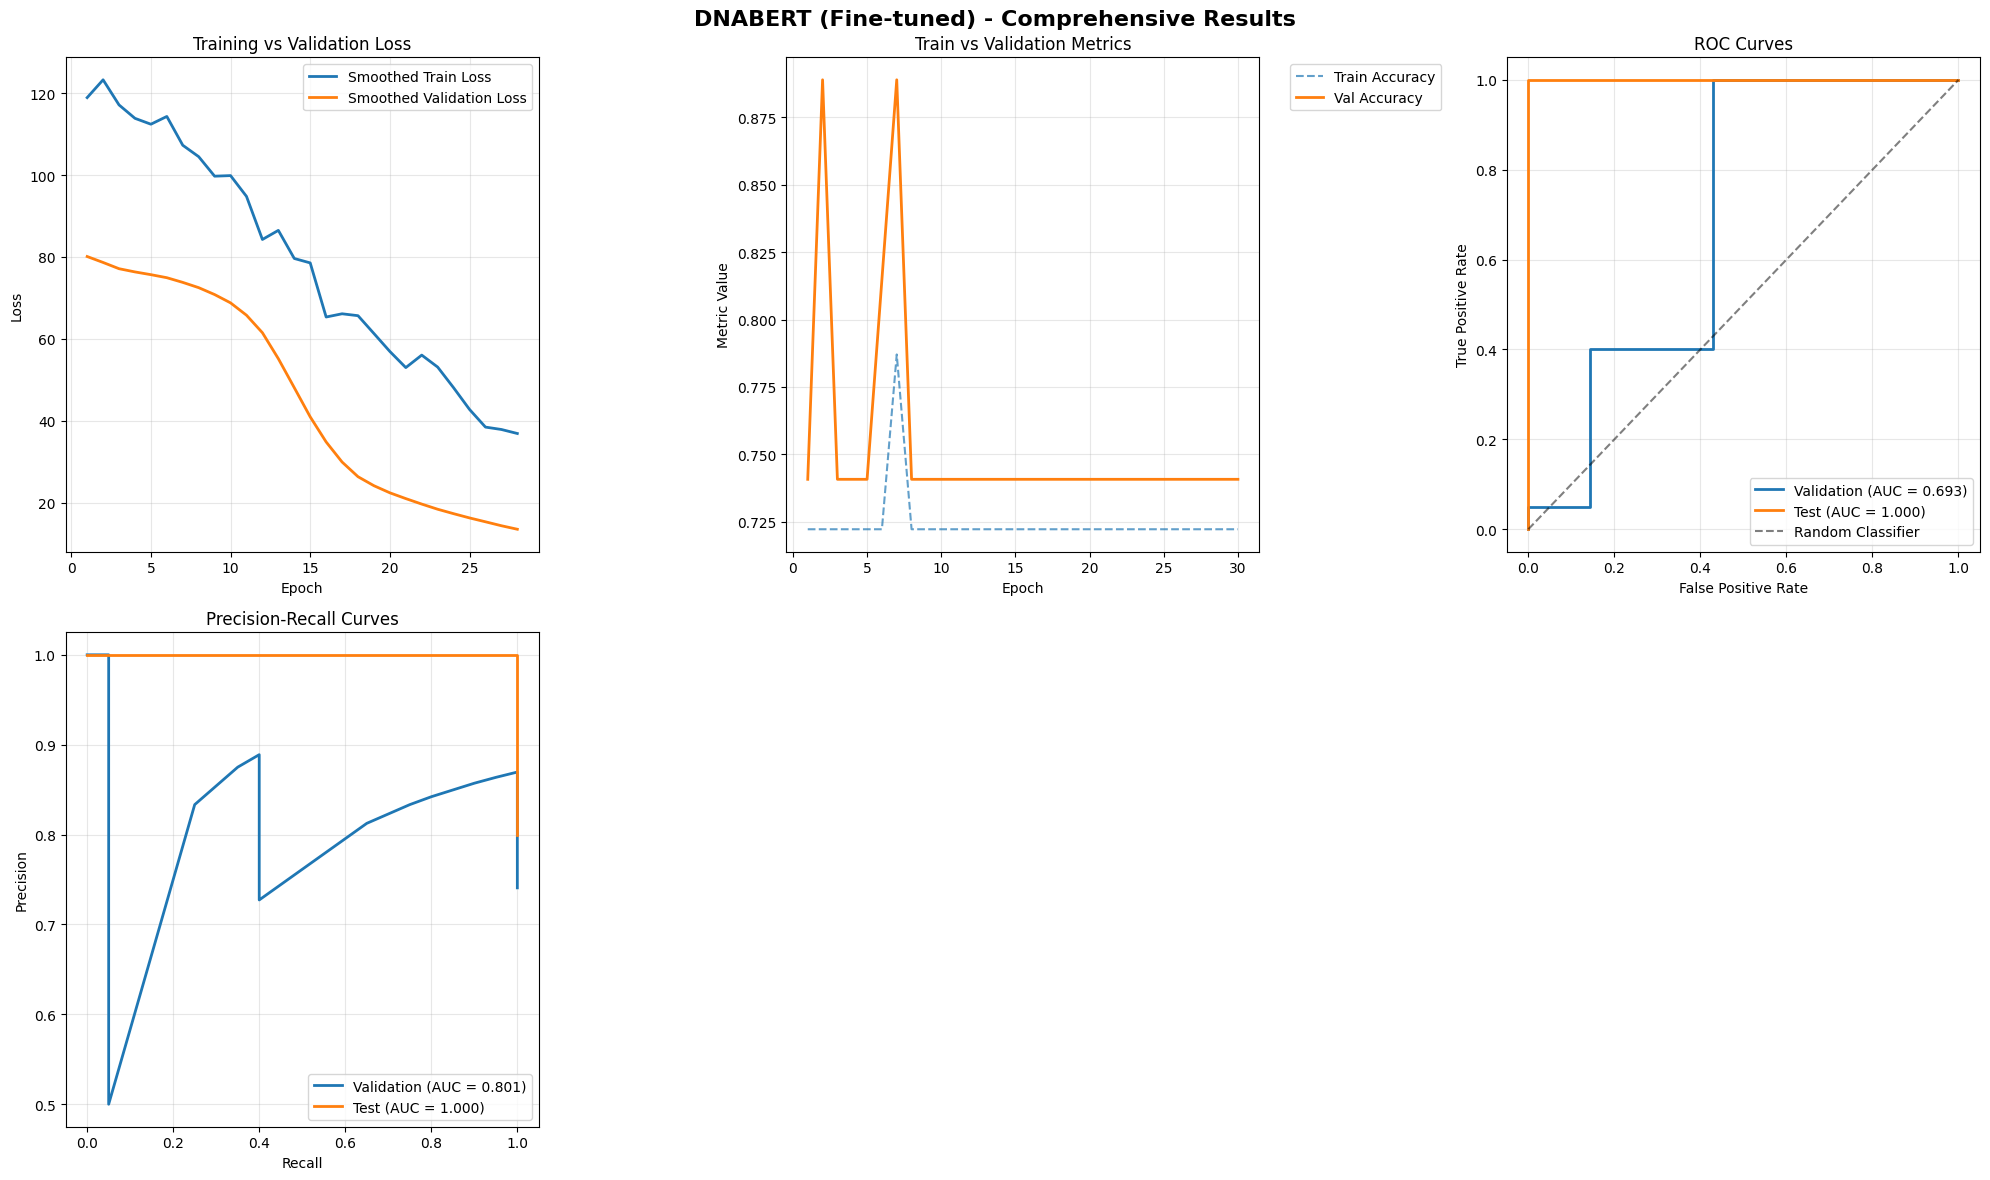

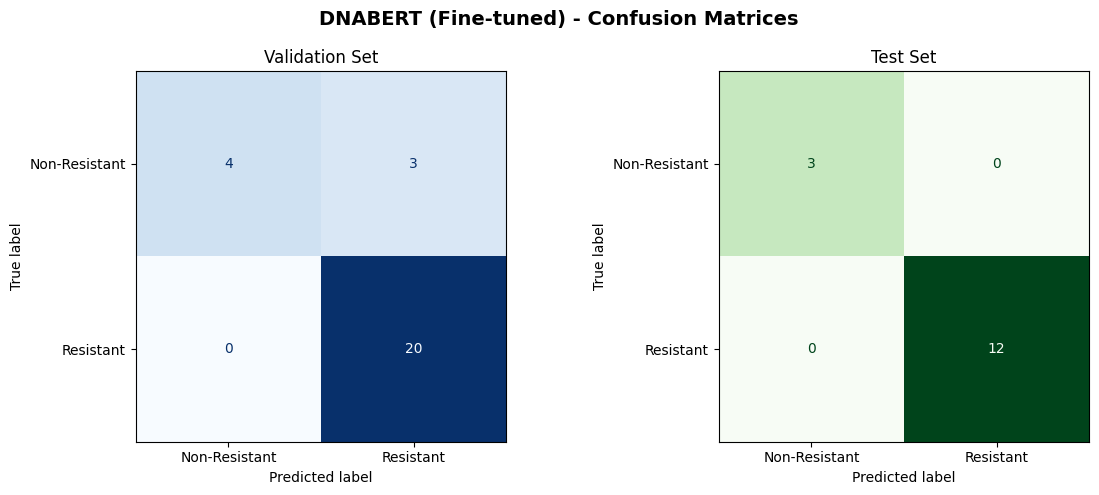


DNABERT (Fine-tuned) - Detailed Results Summary:
Validation F1: 0.9302
Test F1: 1.0000
Trainable parameters: 89,191,681


In [22]:
print("PLOTTING DNABERT (FINE-TUNED) RESULTS")
print("="*50)

# Call plotting function with single model setup
plot_dnabert_results(
    model_results=dnabert_results,                 # the dictionary with val metrics and model
    training_history=dnabert_history,             # history returned from training
    test_results=dnabert_test_results,            # results on test set
    model_name="DNABERT (Fine-tuned)"
)

# Print detailed summary
print(f"\nDNABERT (Fine-tuned) - Detailed Results Summary:")
print(f"Validation F1: {dnabert_results['val_f1']:.4f}")
print(f"Test F1: {dnabert_test_results['test_f1']:.4f}")
print(f"Trainable parameters: {dnabert_results['trainable_params']:,}")

### **PLOT DNABERT (FROZEN) RESULTS**

PLOTTING DNABERT (FROZEN) RESULTS


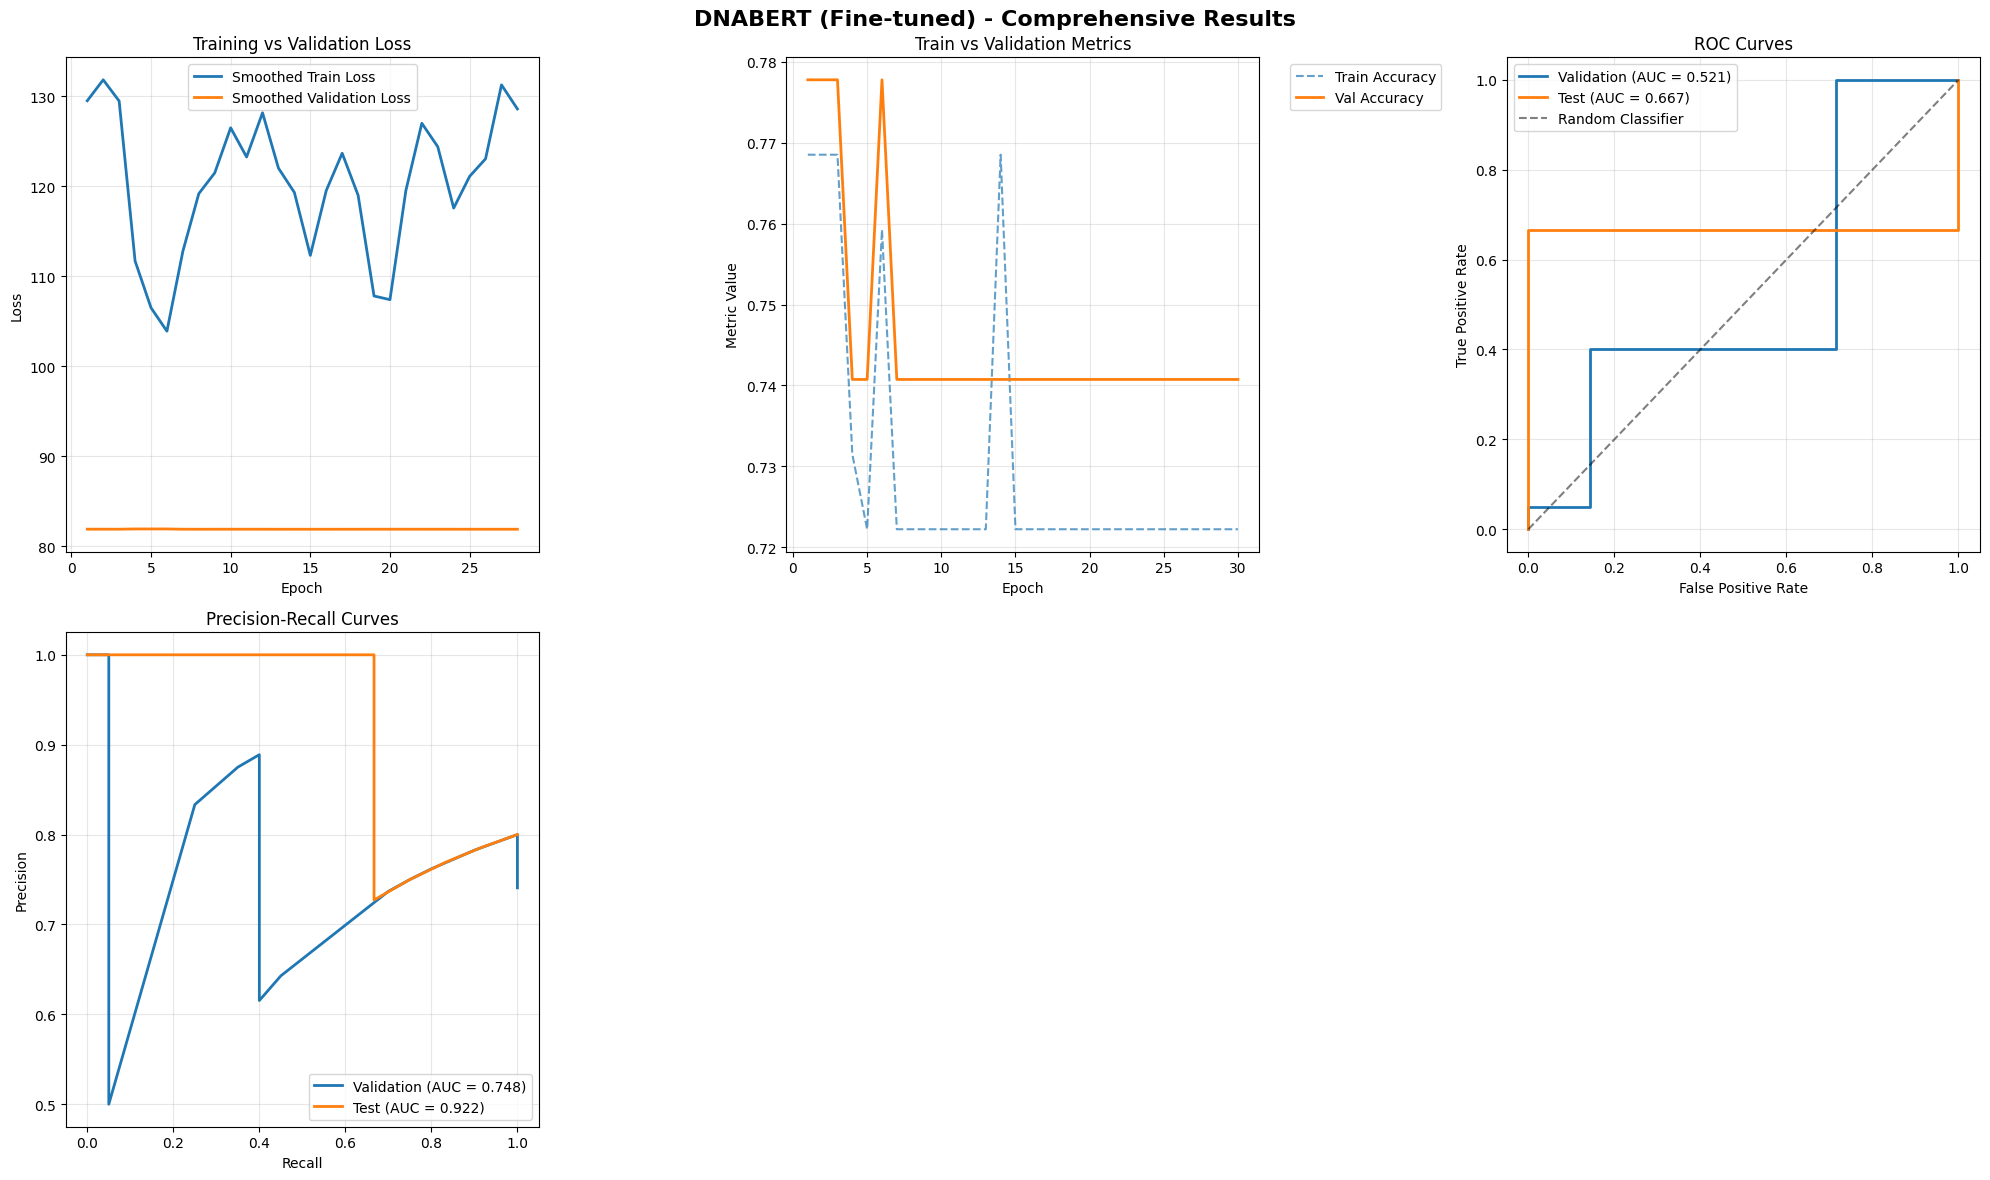

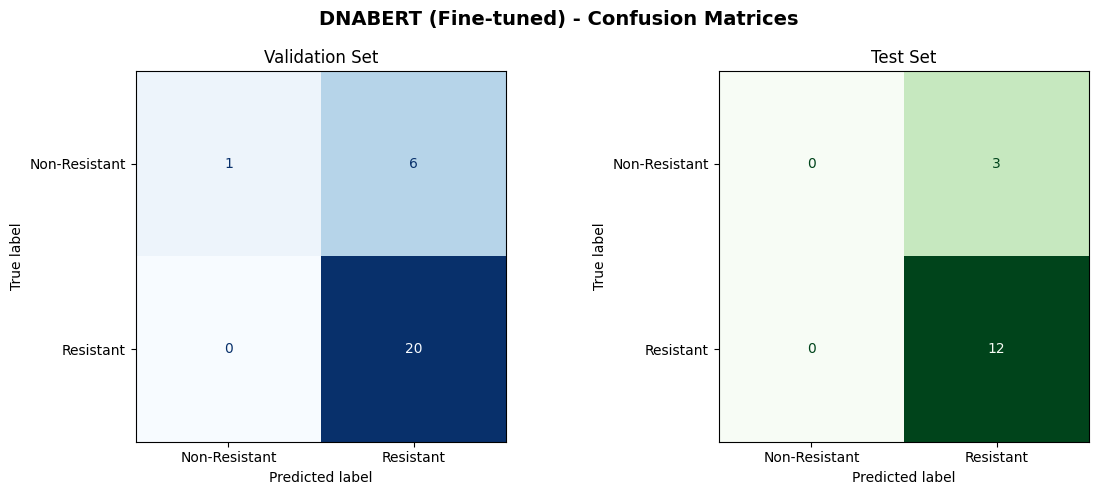


DNABERT (Frozen) - Detailed Results Summary:
Validation F1: 0.8696
Test F1: 0.8889
Trainable parameters: 769


In [23]:
print("PLOTTING DNABERT (FROZEN) RESULTS")
print("="*50)

plot_dnabert_results(
    model_results=dnabert_frozen_result,                 # the dictionary with val metrics and model
    training_history=dnabert_frozen_history,             # history returned from training
    test_results=dnabert_frozen_test_results,            # results on test set
    model_name="DNABERT (Fine-tuned)"
)

# Print detailed summary
print(f"\nDNABERT (Frozen) - Detailed Results Summary:")
print(f"Validation F1: {dnabert_frozen_result['val_f1']:.4f}")
print(f"Test F1: {dnabert_frozen_test_results['test_f1']:.4f}")
print(f"Trainable parameters: {dnabert_frozen_result['trainable_params']:,}")

### **PLOT DNABERT (FROZEN + LoRA) RESULTS**

PLOTTING DNABERT (FROZEN + LoRA) RESULTS


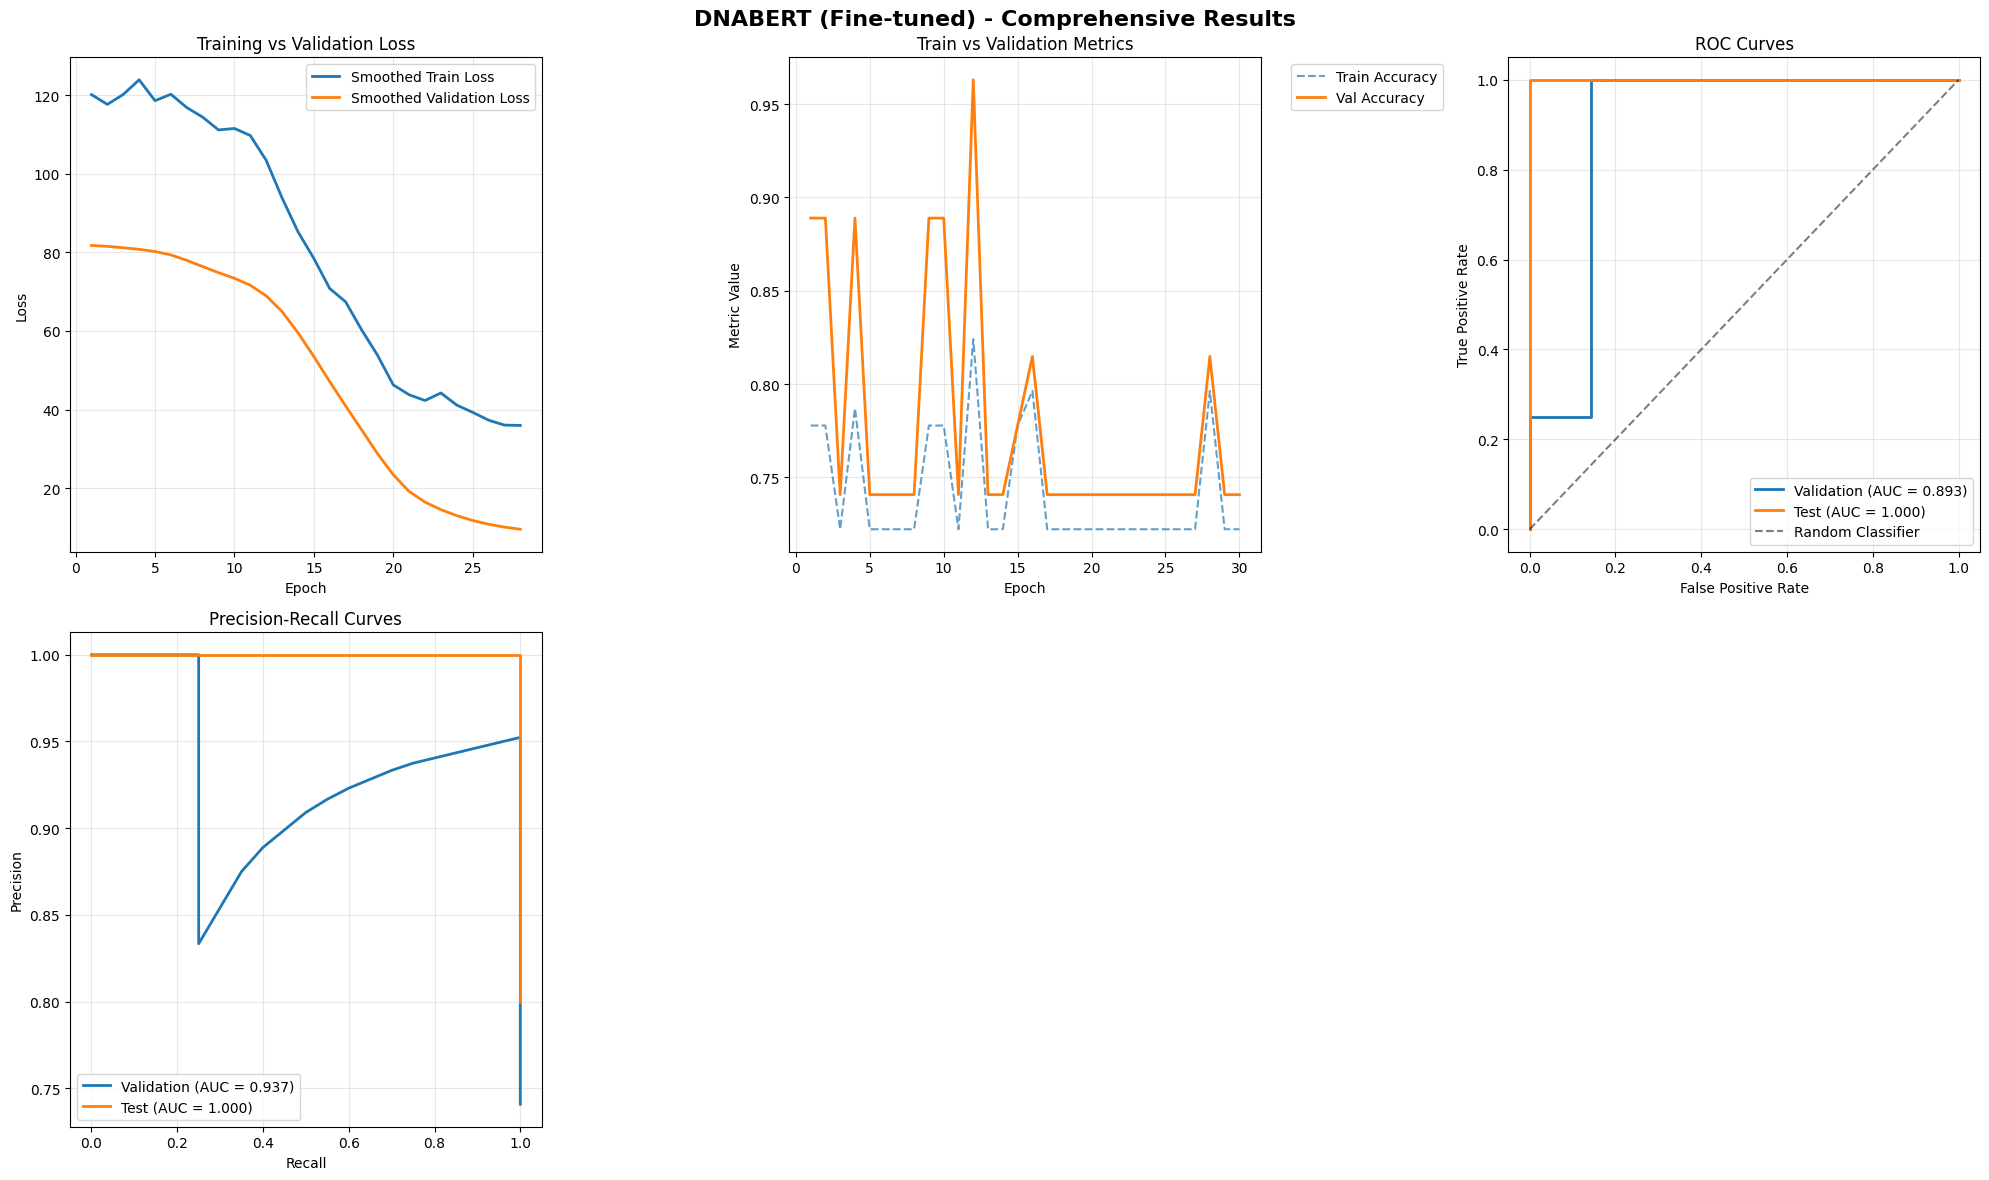

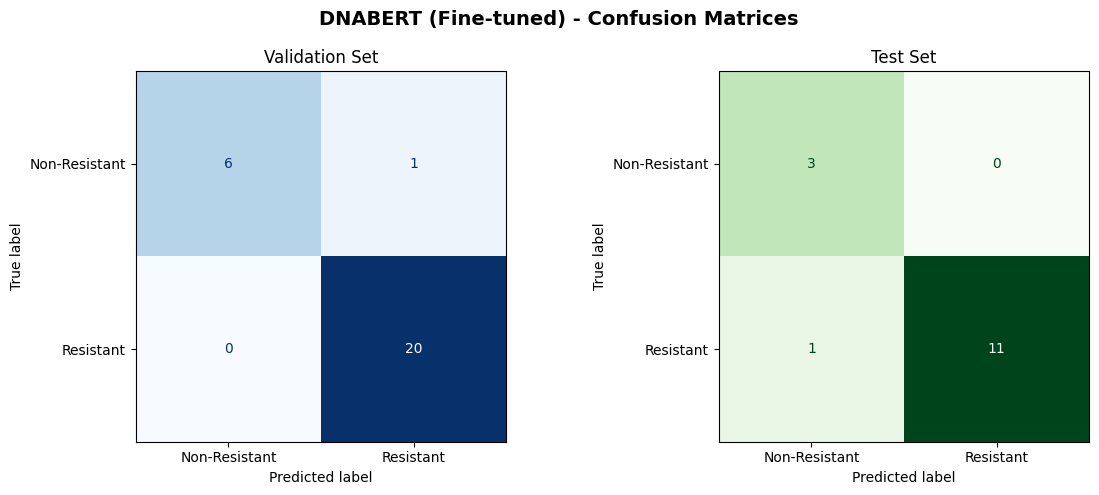


DNABERT (Frozen) - Detailed Results Summary:
Validation F1: 0.9756
Test F1: 0.9565
Trainable parameters: 590,593


In [24]:
print("PLOTTING DNABERT (FROZEN + LoRA) RESULTS")
print("="*50)

plot_dnabert_results(
    model_results=dnabert_lora_result,                 # the dictionary with val metrics and model
    training_history=dnabert_lora_history,             # history returned from training
    test_results=dnabert_lora_test_results,            # results on test set
    model_name="DNABERT (Fine-tuned)"
)

# Print detailed summary
print(f"\nDNABERT (Frozen) - Detailed Results Summary:")
print(f"Validation F1: {dnabert_lora_result['val_f1']:.4f}")
print(f"Test F1: {dnabert_lora_test_results['test_f1']:.4f}")
print(f"Trainable parameters: {dnabert_lora_result['trainable_params']:,}")